In [70]:
import pandas as pd
import numpy as np
import sklearn as sk
import statsmodels.api as sm
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import matplotlib
import random as rd
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import math
from scipy.optimize import minimize, NonlinearConstraint, BFGS
import itertools as it
import seaborn as sn

In [2]:
def count_permutationlist(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(len(df)-d+1):
        slice_df = df[i:i+d]
        sort_slice = sorted(slice_df)
        for j in range(d):
            slice_df[slice_df.index(sort_slice[j])] = j
        count_p[perm.index(tuple(slice_df))] += 1
    return count_p
def count_permutation(df, d):
    r = list(range(d))
    perm = list(it.permutations(r))
    count_p = [0]*len(perm)
    for i in range(df.size-d+1):
        slice_df = df.copy().iloc[i:i+d]
        sort_slice = slice_df.copy().sort_values()
        for j in range(d):
            #print(slice_df[slice_df==sort_slice.iloc[j]])
            slice_df.replace(slice_df[slice_df==sort_slice.iloc[j]].item(), j, inplace = True)
        count_p[perm.index(tuple(slice_df.tolist()))] += 1
    return count_p
def entropy(perm:list):
    allperm = sum(perm)
    ent = 0
    for i in range(len(perm)):
        probability = perm[i]/allperm
        if probability !=0:
            ent -= probability * math.log2(probability)
    return ent

In [3]:
def fun(X, alp: float, beta: float, max_kf: float, trend: float, season: float):
    j = 2
    k = 2
    for i in X[2:]:
        X[i] = (alp * X[i-dt.timedelta(1/24)] + beta * X[i-dt.timedelta(2/24)]) + rd.uniform(-max_kf, max_kf) + trend * j
        if k%(7*24)==0:
            X[i]+=season
        if k%(7*24)==1:
            X[i]-=season
        k+=1
    return X

<AxesSubplot:>

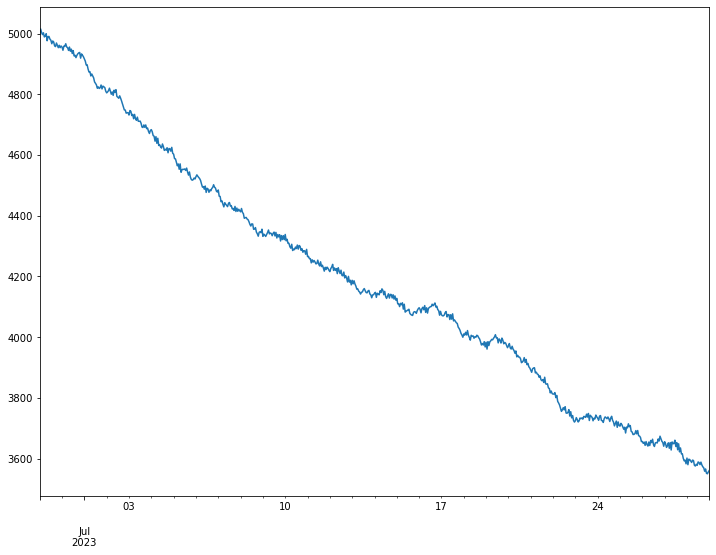

In [4]:
datelist = pd.date_range(start='29/06/2023 00:00:00', end='29/07/2023', freq='H').to_series()
datelist.index = datelist
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
ts = fun(datelist.copy(), 0.4501, 0.5483, 15, 2, 0)
ts.plot(figsize=(12,9))

Проверим скользящее среднее

<AxesSubplot:>

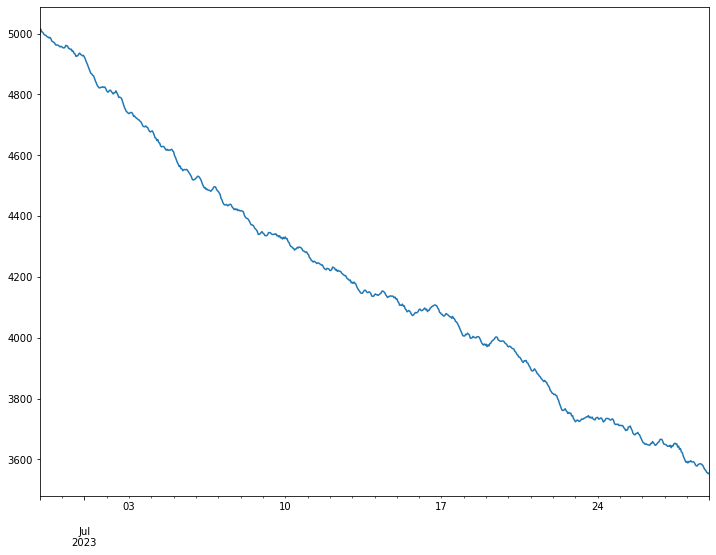

In [5]:
SMA3 = ts.rolling(window=3).mean()
SMA3['29/06/2023 00:00:00'] = 5000.0
SMA3['29/06/2023 01:00:00'] = 5015.0
SMA3.plot(figsize=(12,9))

In [6]:
SMA = []
for i in range(2,11):
    SMAi = ts.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = ts[j]
    SMA.append(SMAi)

In [8]:
datelist['29/06/2023 00:00:00'] = 0.0
datelist['29/06/2023 01:00:00'] = 0.0
noise = fun(datelist.copy(), 0, 0, 15, 0, 0)

Сравним энтропию ряда скользящего среднего с шумом

In [16]:
for d in range(2,11):
    print("len of slice: ", d)
    c = count_permutation(ts.copy(), d)
    c1 = count_permutationlist(noise.copy().tolist(), d)
    print("max entropy: ", math.log2(math.factorial(d)))
    print("noise entropy: ", entropy(c1))
    print("ts entropy: ",entropy(c))
    i = 2
    for mov_avg in SMA:
        Cp = count_permutation(mov_avg.copy(), d)
        print("SMA", i, " entropy: ", entropy(Cp))
        i+=1

len of slice:  2
max entropy:  1.0
noise entropy:  0.9999499058423885
ts entropy:  0.9798687566511528
SMA 2  entropy:  0.9412910282277052
SMA 3  entropy:  0.9052853757202977
SMA 4  entropy:  0.8654698974285928
SMA 5  entropy:  0.8284184299379681
SMA 6  entropy:  0.7436012269934464
SMA 7  entropy:  0.732901009176448
SMA 8  entropy:  0.6902992591390373
SMA 9  entropy:  0.6500224216483541
SMA 10  entropy:  0.6532373252314684
len of slice:  3
max entropy:  2.584962500721156
noise entropy:  2.5830453240692948
ts entropy:  2.506079766285764
SMA 2  entropy:  2.2355416506494254
SMA 3  entropy:  2.1632920736729764
SMA 4  entropy:  1.9550325168672789
SMA 5  entropy:  1.8322332222891515
SMA 6  entropy:  1.650922211507949
SMA 7  entropy:  1.5750474771747756
SMA 8  entropy:  1.4630036654249272
SMA 9  entropy:  1.3694727782752452
SMA 10  entropy:  1.3316456022348602
len of slice:  4
max entropy:  4.584962500721156
noise entropy:  4.5683406491597465
ts entropy:  4.338850047297507
SMA 2  entropy:  3.7

Сравним энтропию стационарного ряда cо скользящим среднем с энтропией шумового скользящего среднего

<AxesSubplot:>

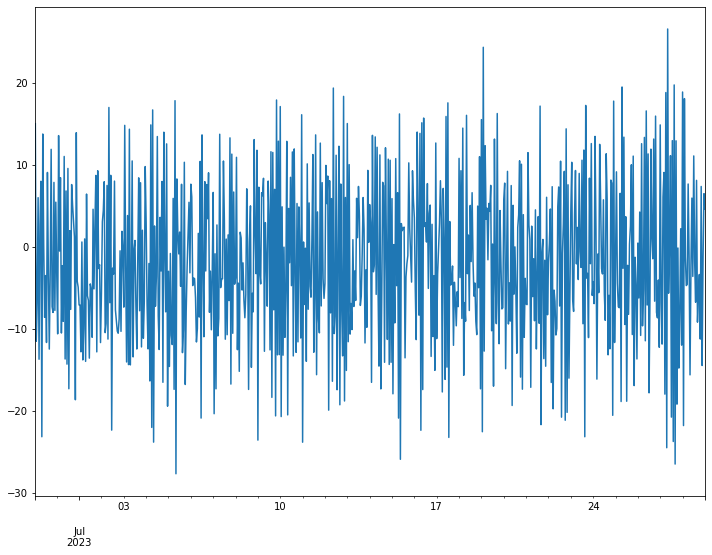

In [17]:
tsdiff = ts.diff(periods=1).dropna()
tsdiff.plot(figsize=(12,9))

In [18]:
SMAdiff = []
for i in range(2,7):
    SMAi = tsdiff.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = tsdiff[j]
    SMAdiff.append(SMAi)
SMAnoise = []
for i in range(2,7):
    SMAi = noise.rolling(window=i).mean()
    for j in range (i):
        SMAi[j] = noise[j]
    SMAnoise.append(SMAi)

In [25]:
len(SMAdiff)

5

In [26]:
for d in range(2,11):
    print("len of slice: ", d)
    c1 = count_permutationlist(noise.copy().tolist(), d)
    c2 = count_permutation(tsdiff.copy(), d)
    print("max entropy: ", math.log2(math.factorial(d)))
    print("noise entropy: ", entropy(c1))
    print("tsdiff entropy: ",entropy(c2))
    for i in range(0, 5):
        Cp = count_permutation(SMAdiff[i].copy(), d)
        Cp_noise = count_permutationlist(SMAnoise[i].copy().tolist(), d)
        print("SMAdiff", i+2, " entropy: ", entropy(Cp))
        print("SMAnoise", i+2, " entropy: ", entropy(Cp_noise))

len of slice:  2
max entropy:  1.0
noise entropy:  0.9999499058423885
tsdiff entropy:  0.9997641710419596
SMAdiff 2  entropy:  0.999831154661169
SMAnoise 2  entropy:  0.9998608466987451
SMAdiff 3  entropy:  0.999998604637965
SMAnoise 3  entropy:  0.9997272511099724
SMAdiff 4  entropy:  0.999965115679202
SMAnoise 4  entropy:  0.9987472979361685
SMAdiff 5  entropy:  0.999831154661169
SMAnoise 5  entropy:  0.9993264148387212
SMAdiff 6  entropy:  0.9999316262021697
SMAnoise 6  entropy:  0.9999777360731135
len of slice:  3
max entropy:  2.584962500721156
noise entropy:  2.5830453240692948
tsdiff entropy:  2.5405883291203493
SMAdiff 2  entropy:  2.5665112211156815
SMAnoise 2  entropy:  2.5030909852638485
SMAdiff 3  entropy:  2.5818366271820063
SMAnoise 3  entropy:  2.484243677444536
SMAdiff 4  entropy:  2.5833582690151347
SMAnoise 4  entropy:  2.43424091892927
SMAdiff 5  entropy:  2.583247289865517
SMAnoise 5  entropy:  2.455913343885407
SMAdiff 6  entropy:  2.582986946640352
SMAnoise 6  ent

Стационарный ряд не проверяется на прогнозируемость с помощью  энтропии даже со скользящим средним(очевидно).
Проверим как будет влиять количества шума в данных на энтропию ряда, ряда со скользящим средним.

In [76]:
datelist['29/06/2023 00:00:00'] = 5000.0
datelist['29/06/2023 01:00:00'] = 5015.0
list_ts = []
list_ts_ent3 = []
list_ts_ent7 = []
list_SMA3 = []
list_SMA3_ent3 = []
list_SMA3_ent7 = []
list_SMA5 = []
list_SMA5_ent3 = []
list_SMA5_ent7 = []
list_SMA7 = []
list_SMA7_ent3 = []
list_SMA7_ent7 = []
list_rd_walk = []
list_rd_walk_ent3 = []
list_rd_walk_ent7 = []
list_noise = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,100]
max_ent3 = math.log2(math.factorial(3))
max_ent7 = math.log2(math.factorial(7))
noise_ent3 = entropy(count_permutationlist(noise.copy().tolist(), 3))
noise_ent7 = entropy(count_permutationlist(noise.copy().tolist(), 7))
for i in list_noise:
    ts_l = fun(datelist.copy(), 0.4501, 0.5483, i, 2, 0)
    list_ts.append(ts_l)
    list_ts_ent3.append(entropy(count_permutation(ts_l.copy(), 3)))
    list_ts_ent7.append(entropy(count_permutation(ts_l.copy(), 7)))
    SMA_l3 = ts_l.rolling(window=3).mean()
    for j in range (2):
        SMA_l3[j] = ts_l[j]
    list_SMA3.append(SMA_l3)
    list_SMA3_ent3.append(entropy(count_permutation(SMA_l3.copy(), 3)))
    list_SMA3_ent7.append(entropy(count_permutation(SMA_l3.copy(), 7)))
    SMA_l5 = ts_l.rolling(window=5).mean()
    for j in range (4):
        SMA_l5[j] = ts_l[j]
    list_SMA5.append(SMA_l5)
    list_SMA5_ent3.append(entropy(count_permutation(SMA_l5.copy(), 3)))
    list_SMA5_ent7.append(entropy(count_permutation(SMA_l5.copy(), 7)))
    SMA_l7 = ts_l.rolling(window=7).mean()
    for j in range (6):
        SMA_l7[j] = ts_l[j]
    list_SMA7.append(SMA_l7)
    list_SMA7_ent3.append(entropy(count_permutation(SMA_l7.copy(), 3)))
    list_SMA7_ent7.append(entropy(count_permutation(SMA_l7.copy(), 7)))
    rd_walk = fun(datelist.copy(), 1, 0, i, 0, 0)
    list_rd_walk.append(rd_walk)
    list_rd_walk_ent3.append(entropy(count_permutationlist(rd_walk.copy().tolist(), 3)))
    list_rd_walk_ent7.append(entropy(count_permutationlist(rd_walk.copy().tolist(), 7)))

In [28]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [77]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[0].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[0].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[0].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[0].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[0].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 0", xaxis_title="Datetime", yaxis_title="Value")

In [78]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[5].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[5].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[5].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[5].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[5].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 5", xaxis_title="Datetime", yaxis_title="Value")

In [79]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[11].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[11].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[11].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[11].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[11].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 15", xaxis_title="Datetime", yaxis_title="Value")

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[14].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[14].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[14].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[14].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[14].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 30", xaxis_title="Datetime", yaxis_title="Value")

In [81]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=datelist.index, y=list_ts[-1].values, name='Time Series'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA3[-1].values, name='Moving mean of 3 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA5[-1].values, name='Moving mean of 5 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_SMA7[-1].values, name='Moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk[-1].values, name='Random walk'))
fig.update_layout(legend_orientation='h', legend=dict(x=.5,y=0.1, xanchor="center"), title="Plot TS; Noise 100", xaxis_title="Datetime", yaxis_title="Value")

In [84]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent3, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent3, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA5_ent3, name='Entropy of moving mean of 5 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent3, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk_ent3, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=[max_ent3]*20, name='Max entropy'))
fig.add_trace(go.Scatter(x=list_noise, y=[noise_ent3]*20, name='Noise entropy'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropy of permutation 3", xaxis_title="Noise", yaxis_title="Entropy")

In [83]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=list_noise, y=list_ts_ent7, name='Entropy of Time Series'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA3_ent7, name='Entropy of moving mean of 3 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA5_ent7, name='Entropy of moving mean of 5 average'))
fig.add_trace(go.Scatter(x=list_noise, y=list_SMA7_ent7, name='Entropy of moving mean of 7 average'))
fig.add_trace(go.Scatter(x=datelist.index, y=list_rd_walk_ent7, name='Entropy of random walk'))
fig.add_trace(go.Scatter(x=list_noise, y=[max_ent7]*20, name='Max entropy'))
fig.add_trace(go.Scatter(x=list_noise, y=[noise_ent7]*20, name='Noise entropy'))
fig.update_layout(legend_orientation='h', legend=dict(x=.7,y=0.1, xanchor="right"), title="Plot entropyof permutation 7", xaxis_title="Noise", yaxis_title="Entropy")

Посчитаем матрицы корреляций

In [88]:
corr_df_3 = pd.DataFrame(data={'TS':list_ts_ent3,'SMA3':list_SMA3_ent3,'SMA5': list_SMA5_ent3,'SMA7':list_SMA7_ent3,'noise':[noise_ent3]*20, 'RW':list_rd_walk_ent3})
corr_df_7 = pd.DataFrame(data={'TS':list_ts_ent7,'SMA3':list_SMA3_ent7,'SMA5': list_SMA5_ent7,'SMA7':list_SMA7_ent7,'noise':[noise_ent7]*20, 'RW':list_rd_walk_ent7})

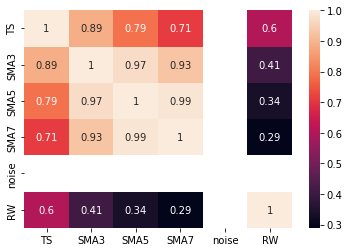

In [89]:
corr3 = corr_df_3.corr()
sn.heatmap(corr3, annot=True)
plt.show()

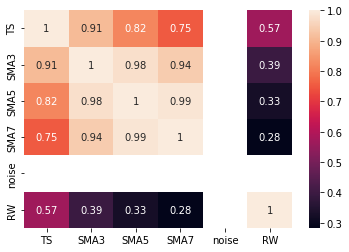

In [90]:
corr7 = corr_df_7.corr()
sn.heatmap(corr7, annot=True)
plt.show()